# AI Project Lifecycle

![AI Lifecycle](./assets/lifecycle.png)


## Step 2: Data Acquisiton for PCB Component Detection

Here, we have gathered data from the following sources, with different types of data:

These datasets have annotated images of PCBs highlighting actual components, this can be used to identify missing components by comparing it with a known good PCB's output.
- pcb-oriented-detection: https://www.kaggle.com/datasets/yuyi1005/pcb-oriented-detection
- pcb-fault-detection: (Very Poor Quality) https://www.kaggle.com/datasets/animeshkumarnayak/pcb-fault-detection
- pcb-component-detection: https://sites.google.com/view/chiawen-kuo/home/pcb-component-detection
- FICS-PCB: https://www.researchgate.net/publication/344475848_FICS-PCB_A_Multi-Modal_Image_Dataset_for_Automated_Printed_Circuit_Board_Visual_Inspection https://trust-hub.org/#/data/fics-pcb also at https://universe.roboflow.com/erl-n2gvo/component-detection-caevk/browse
- PCB-Vision: https://arxiv.org/pdf/2401.06528 https://zenodo.org/records/10617721
- CompDetect Dataset: https://universe.roboflow.com/dataset-lmrsw/compdetect

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import xml.etree.ElementTree as  ET
from shutil import copyfile
import os
import os.path as path
import shutil
import pathlib
from pathlib import Path
from tqdm.std import tqdm
import random
import json
import random
import glob
import cv2
import regex as re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import enum
from enum import Enum, auto

import sys

sys.path.insert(0, "..")
from yolo_visualize import sample_yolo_dataset

In [2]:
@enum.verify(enum.UNIQUE, enum.CONTINUOUS)
class Component(enum.IntEnum):
    battery = 0
    button = 1
    buzzer = 2
    capacitor = 3
    clock = 4
    connector = 5
    diode = 6
    display = 7
    fuse = 8
    heatsink = 9
    ic = 10
    inductor = 11
    led = 12
    pads = 13
    pins = 14
    potentiometer = 15
    relay = 16
    resistor = 17
    switch = 18
    transducer = 19
    transformer = 20
    transistor = 21


Component.aliases = {
    # Plurals
    "diodes": Component.diode,
    "resistors": Component.resistor,
    "transistors": Component.transistor,
    "capacitors": Component.capacitor,
    "inductors": Component.inductor,
    "fuses": Component.fuse,
    "ics": Component.ic,
    "transducers": Component.transducer,
    "transformers": Component.transformer,
    #
    # Subsets
    "electrolytic_capacitor": Component.capacitor,
    "capacitor_jumper": Component.capacitor,
    "resistor_jumper": Component.resistor,
    "jumper": Component.connector,
    "zener_diode": Component.diode,
    #
    # Look like ICs
    "diode_zener_array": Component.ic,
    "resistor_network": Component.ic,
    #
    # Look like SMD capacitors, and are very hard to tell apart
    "ferrite_bead": Component.capacitor,
    "emi_filter": Component.capacitor,
}

In [3]:
IGNORE_COMPONENTS = {"text", "component_text", "unknown", "test_point"}

In [4]:
CLASSES = list(Component._member_names_)
CLASSES

['battery',
 'button',
 'buzzer',
 'capacitor',
 'clock',
 'connector',
 'diode',
 'display',
 'fuse',
 'heatsink',
 'ic',
 'inductor',
 'led',
 'pads',
 'pins',
 'potentiometer',
 'relay',
 'resistor',
 'switch',
 'transducer',
 'transformer',
 'transistor']

In [5]:
COMPONENTS_DATA_DIR = Path("./components_data")

In [6]:
def sane_mkdir(v):
    if not path.isdir(v):
        os.mkdir(v)

In [7]:
# clear_old_data = True
clear_old_data = False
if clear_old_data and path.exists(COMPONENTS_DATA_DIR):
    shutil.rmtree(COMPONENTS_DATA_DIR)
sane_mkdir(COMPONENTS_DATA_DIR)

In [8]:
DATASET_GROUPS = ["train", "test", "valid"]
for g in DATASET_GROUPS:
    sane_mkdir(COMPONENTS_DATA_DIR / g)
    sane_mkdir(COMPONENTS_DATA_DIR / g / "images")
    sane_mkdir(COMPONENTS_DATA_DIR / g / "labels")

In [9]:
# Define metadata for dataset
with open(COMPONENTS_DATA_DIR / "data.yaml", "w") as f:
    f.write(
        f"""train: ../train/images
val: ../valid/images
test: ../test/images

nc: {len(CLASSES)}
names: [{",".join(f"'{s}'" for s in CLASSES)}]
"""
    )

#### Transfer files from one YOLO dataset to another, while mapping class names

In [10]:
def map_one_dataset_group(
    from_path_top: Path, to_path_top: Path, dataset_group: str, mapping: dict[int, int]
):
    from_path = from_path_top / dataset_group
    to_path = to_path_top / dataset_group
    shutil.copytree(from_path / "images", to_path / "images", dirs_exist_ok=True)
    to_labels_path = to_path / "labels"
    to_labels_path.mkdir(parents=True, exist_ok=True)
    for from_child_path in tqdm((from_path / "labels").iterdir()):
        to_child_path = to_labels_path / from_child_path.name
        with open(from_child_path, "r") as f:
            with open(to_child_path, "w") as t:
                for line in f:
                    class_id, x, y, w, h = line.strip().split()
                    res = mapping[int(class_id)]
                    if res == -1:
                        continue
                    new_class_id = str(res)
                    t.write(f"{new_class_id} {x} {y} {w} {h}\n")


def map_dataset(from_path_top: Path, to_path_top: Path, mapping: dict[int, int]):
    for g in tqdm(DATASET_GROUPS):
        map_one_dataset_group(from_path_top, to_path_top, g, mapping)

### CompDetect Dataset

From: https://universe.roboflow.com/dataset-lmrsw/compdetect

This dataset helps detect components, but it is in Roboflow, which does not allow us to directly download the original images which are of higher quality. If you go to https://universe.roboflow.com/dataset-lmrsw/compdetect/dataset/23 and try to "Download Dataset" and select YoloV11 or something, the quality is terrible for the images. Also it contains many augmented images, which are not needed, we will do the augmenting ourselves, while training.

(This dataset is almost certainly copied from some other source, but it's not listed, and I could not find it during my data hunting, so I don't know what it is...)

So, the steps I took to download this are:
- Go to https://universe.roboflow.com/dataset-lmrsw/compdetect
- Select Fork Project
- Fill in the API_KEY and PROJECT_ID in my_secrets.py
- Run roboflow_download.py, this saves all images to ./temp_images
- Run roboflow_save_labels.py, this saves all data to ./temp_data, but it is in Roboflow JSON API response format so we have to convert it to the YOLO format manually.


### FICS-PCB:

Paper: https://www.researchgate.net/publication/344475848_FICS-PCB_A_Multi-Modal_Image_Dataset_for_Automated_Printed_Circuit_Board_Visual_Inspection

Download from: https://trust-hub.org/#/data/fics-pcb

The above link has a ~79GB dataset (yes, I downloaded it all), with all the images in individual ZIPs, and the annotations are in some horrible mix of CSV for the class labels and JSON for the bounding box positions.

But in the course of my data hunting I also found the dataset mirrored at https://universe.roboflow.com/erl-n2gvo/component-detection-caevk/, uploaded by someone else who also wanted to use the dataset and did all the hard-work for me. So, we will use the same methodology as the above CompDetect dataset, placing both the datasets images & labels in ./temp_images & ./temp_data together, and then parsing them at the same time into the YOLO format.

In [11]:
# The CompDetect also has some images from the WACV dataset, but not all of them, so we will need to remove these extra images.
# Luckily they have the same file names as the original, so it's easy to filter them out.
skip_files = set(os.listdir("./pcb_wacv_2019/"))

In [12]:
temp_data_path = Path("./temp_data/")
temp_images_path = Path("./temp_images/")

for image_path in tqdm(list(temp_images_path.iterdir())):
    if image_path.with_suffix("").name in skip_files:
        print(f"Skipping: {image_path}")
        continue
    data_path = temp_data_path / (image_path.with_suffix(".json").name)
    with open(data_path) as json_data:
        json_data = json.load(json_data)
    image_data = json_data["image"]
    split = image_data["split"]
    annotations = image_data["annotation"]
    shutil.copyfile(
        image_path, COMPONENTS_DATA_DIR / split / "images" / image_path.name
    )
    width = int(annotations["width"])
    height = int(annotations["height"])
    dw = 1.0 / width
    dh = 1.0 / height

    # Calculate center, width, and height of the bbox in relative dimension
    with open(
        COMPONENTS_DATA_DIR / split / "labels" / (image_path.with_suffix(".txt").name),
        "w",
    ) as f:
        for box in annotations["boxes"]:
            class_name = str(box["label"]).lower()
            class_id = (
                Component.aliases.get(class_name, None) or Component[class_name]
            )._value_
            x = float(box["x"])
            y = float(box["y"])
            width = float(box["width"])
            height = float(box["height"])
            rel_x_center = x * dw
            rel_y_center = y * dh
            rel_width = width * dw
            rel_height = height * dh
            f.write(
                f"{class_id} {rel_x_center} {rel_y_center} {rel_width} {rel_height}\n"
            )

  0%|          | 0/630 [00:00<?, ?it/s]

Skipping: temp_images\ACM-109_Top.jpg
Skipping: temp_images\Arty_Bottom.jpg
Skipping: temp_images\Arty_Top.jpg


100%|██████████| 630/630 [09:11<00:00,  1.14it/s]


Also, the strange glow on some (s14_*.png) images comes from the backlight of the scanner, as far as I could tell.

### PCB-Vision: 

Paper at https://arxiv.org/pdf/2401.06528

Download from https://zenodo.org/records/10617721 (11GB)

This dataset is "interesting", we had to apply quite a bit of pre-processing, so much so that we have split it into a separate file "preprocess-pcb-vision.ipynb", that basically converts the dataset into a YOLO format stored at ./PCBVisionYolo

We then combine this converted dataset with the main dataset.

In [13]:
PCB_VISION_YOLO_MAP = {
    0: Component.ic._value_,
    1: Component.capacitor._value_,
    2: Component.connector._value_,
}

map_dataset(Path("./PCBVisionYolo/"), COMPONENTS_DATA_DIR, PCB_VISION_YOLO_MAP)

37it [00:01, 20.42it/s]0:00<?, ?it/s]
8it [00:00, 16.54it/s]00:12<00:25, 12.60s/it]
8it [00:00, 11.70it/s]00:13<00:05,  5.72s/it]
100%|██████████| 3/3 [00:17<00:00,  5.70s/it]


### pcb-component-detection

From https://sites.google.com/view/chiawen-kuo/home/pcb-component-detection



In [14]:
WACV_DIR = Path("./pcb_wacv_2019/")

In [15]:
boards = [v for v in os.listdir(WACV_DIR) if path.isdir(WACV_DIR / v)]

#### Converting Pascal VOC Format of Dataset to YOLO Format

**Pascal VOC** : $(x_{min}, y_{min}, x_{max},y_{max})$

**YOLO** : $(x_{center-norm},y_{center-norm}, w_{norm}, h_{norm})$

$x_{norm}$ = $\frac{x}{widthofWholeImage}$

$y_{norm}$ = $\frac{y}{heightofWholeImage}$

$w_{norm}$ = $\frac{w}{widthofWholeImage}$

$h_{norm}$ = $\frac{h}{heightofWholeImage}$

In [16]:
def get_yolo_class_name(v: str):
    if v.startswith('"'):
        return v.split('"')[1].replace(" ", "_").lower()
    return v.split()[0].lower()

In [17]:
def convert_bbox_to_yolo(
    size: tuple[int, int], box: tuple[int, int, int, int]
) -> tuple[int, int, int, int]:
    """Convert bounding box coordinates from PASCAL VOC format to YOLO format.

    :param size: A tuple of the image size: (width, height)
    :param box: A tuple of the PASCAL VOC bbox: (xmin, ymin, xmax, ymax)
    :return: A tuple of the YOLO bbox: (x_center, y_center, width, height)
    """
    # Calculate relative dimensions
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]

    # Calculate center, width, and height of the bbox in relative dimension
    rel_x_center = (box[0] + box[2]) / 2.0 * dw
    rel_y_center = (box[1] + box[3]) / 2.0 * dh
    rel_width = (box[2] - box[0]) * dw
    rel_height = (box[3] - box[1]) * dh

    return (rel_x_center, rel_y_center, rel_width, rel_height)

In [18]:
def xml_to_txt(input_file: Path, output_txt: Path):
    """Parse an XML file in PASCAL VOC format and convert it to YOLO format.

    :param input_xml: Path to the input XML file.
    :param output_txt: Path to the output .txt file in YOLO format.
    :param classes: A list of class names as strings.
    """
    # Load and parse the XML file
    if input_file.suffix == ".txt":
        # Try to parse .txt as XML
        try:
            # Attempt to parse the file content as XML
            with input_file.open("r", encoding="utf-8") as file:
                file_content = file.read()
            root = ET.fromstring(file_content)
        except ET.ParseError as e:
            print(f"Error parsing {input_file}: {e}")
            return  # Skip this file and continue with the next
    else:
        # Try parsing the XML file (expects XML format)
        try:
            tree = ET.parse(input_file)
            root = tree.getroot()
        except ET.ParseError as e:
            print(f"Error parsing {input_file}: {e}")
            return  # Skip this file and continue with the next

    # Extract image dimensions
    size_element = root.find("size")
    image_width = int(size_element.find("width").text)
    image_height = int(size_element.find("height").text)

    with output_txt.open("w") as file:
        # Process each object in the XML
        for obj in root.iter("object"):
            class_name = get_yolo_class_name(obj.find("name").text)
            if class_name in IGNORE_COMPONENTS:
                continue

            class_id = (
                Component.aliases.get(class_name, None) or Component[class_name]
            )._value_

            # Extract and convert bbox
            xml_box = obj.find("bndbox")
            bbox = (
                float(xml_box.find("xmin").text),
                float(xml_box.find("ymin").text),
                float(xml_box.find("xmax").text),
                float(xml_box.find("ymax").text),
            )
            yolo_bbox = convert_bbox_to_yolo((image_width, image_height), bbox)

            # Write to the output file in YOLO format
            file.write(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")

In [19]:
def map_pascal_to_yolo_one_dataset_group(
    files_list: list[tuple[Path, Path]],
    to_path_with_group: Path,
):
    to_images_path = to_path_with_group / "images"
    to_labels_path = to_path_with_group / "labels"
    to_images_path.mkdir(parents=True, exist_ok=True)
    to_labels_path.mkdir(parents=True, exist_ok=True)
    for image, xml in tqdm(files_list):
        shutil.copy(image, to_images_path / image.name)
        to_child_path = to_labels_path / xml.with_suffix(".txt").name
        xml_to_txt(xml, to_child_path)


def map_pascal_to_yolo_dataset(files_list: list[tuple[Path, Path]], to_path_top: Path):
    rng = random.Random(x=42)
    rng.shuffle(files_list)
    train_end_idx = int(len(files_list) * 0.7)
    test_end_idx = int(len(files_list) * (0.7 + 0.15))
    train_files = files_list[0:train_end_idx]
    test_files = files_list[train_end_idx:test_end_idx]
    val_files = files_list[test_end_idx:]
    vs = [train_files, test_files, val_files]
    for i, g in enumerate(DATASET_GROUPS):
        print(g)
        map_pascal_to_yolo_one_dataset_group(vs[i], to_path_top / g)

In [20]:
files_list = []
for board in boards:
    sub_path = WACV_DIR / board
    xml_file = sub_path / glob.glob("*.xml", root_dir=sub_path)[0]
    img_file = [
        sub_path / filename
        for ext in ["XCF", "xcf", "jpg", "JPG", "jpeg", "gif", "GIF", "png", "PNG"]
        for filename in glob.glob("*." + ext, root_dir=sub_path)
    ][0]

    files_list.append((img_file, xml_file))

In [21]:
map_pascal_to_yolo_dataset(files_list, COMPONENTS_DATA_DIR)

train


100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


test


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


valid


100%|██████████| 8/8 [00:00<00:00,  9.70it/s]


### pcb-oriented-detection

From: https://www.kaggle.com/datasets/yuyi1005/pcb-oriented-detection

Like PCBVision, see "./preprocess-pcb-oriented-detection.ipynb", has many more classes, so there is a huge mapping below.

In [12]:
# -1 means remove this class

PCB_ORIENTED_MAPPING = {
    0: Component.capacitor._value_,  # "C" Capacitor,
    1: -1,  # "J" Junction (Ignore),
    2: Component.resistor._value_,  # "RS" Resistor,
    3: Component.capacitor._value_,  # "CE" Capacitor Electrolytic,
    4: Component.ic._value_,  # "IC-SOT23" IC,
    5: Component.ic._value_,  # "IC-SOP" IC,
    6: Component.ic._value_,  # "IC-TO252" IC,
    7: Component.ic._value_,  # "IC-SOT223" IC,
    8: Component.diode._value_,  # "D" Diode (Probably),
    9: -1,  # "JW" Unknown (Ignore),
    10: Component.clock._value_,  # "X" Crystal,
    11: Component.resistor._value_,  # "R" Resistor (Probably, Again),
    12: Component.ic._value_,  # "IC-BGA" IC,
    13: Component.ic._value_,  # "IC-QFN" IC,
    14: Component.switch._value_,  # "SW" No Instances,
    15: Component.switch._value_,  # "SW-S" No Instances,
    16: Component.ic._value_,  # "IC-SOT235" IC,
    17: Component.ic._value_,  # "IC-SOT89" IC (No Instances),
    18: Component.ic._value_,  # "IC-QFP" IC,
    19: Component.ic._value_,  # "IC-SOT234" IC,
    20: Component.led._value_,  # "LED",
    21: Component.ic._value_,  # "IC-SON" IC,
    22: Component.ic._value_,  # "CA" Capacitor Array (Probably, SMD Component, Actual Functionality Unknown),
    23: Component.inductor._value_,  # "LR" Inductor,
    24: Component.ic._value_,  # "IC-SOT236" IC,
    25: -1,  # "JN-FFC" No Instances ,
    26: Component.ic._value_,  # "RN-N" IC (Resistor Network),
    27: -1,  # "JN-XHH" No Instances,
    28: Component.ic._value_,  # "CN" IC (Capacitor Network),
    29: Component.ic._value_,  # "RN" IC (Resistor Network),
    30: Component.connector._value_,  # "JN-DF" Connector,
    31: Component.connector._value_,  # "JN-DM" Connector (No Instances),
    32: Component.connector._value_,  # "JN-XHV" Connector (No Instances),
    33: Component.ic._value_,  # "IC" IC (Normal IC, No Instances),
    34: -1,  # "P" Unknown,
    35: -1,  # "DC" No Instances,
    36: -1,  # "LA" No Instances,
    37: -1,  # "LB" Unknown,
    38: -1,  # "X-HC49" No Instances,
    39: -1,  # "JN" No Instances,
    40: -1,  # "F" No Instances,
}

In [ ]:
map_dataset(
    Path("./pcb-un-oriented-detection/"), COMPONENTS_DATA_DIR, PCB_ORIENTED_MAPPING
)

133it [00:00, 216.07it/s]00<?, ?it/s]
28it [00:00, 278.76it/s]:00<00:01,  1.06it/s]
29it [00:00, 305.25it/s]:01<00:00,  2.09it/s]
100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


### Tiling

Many of the datasets have really tiny bounding boxes for the small SMD components, so we need to split these images up into larger images, and convert their bounding box annotations appropriately, so that the model can train better as the small SMD components will be larger.

In [10]:
class BoundingBox:
    class_id: int
    abs_x: int
    abs_y: int
    abs_w: int
    abs_h: int
    min_x: int
    min_y: int
    max_x: int
    max_y: int
    img_w: int
    img_h: int
    area: int

    def __init__(
        self,
        *,
        class_id: int,
        abs_x: int,
        abs_y: int,
        abs_w: int,
        abs_h: int,
        img_w: int,
        img_h: int,
        min_x: int,
        min_y: int,
        max_x: int,
        max_y: int,
    ):
        self.class_id = class_id
        self.abs_x = int(abs_x)
        self.abs_y = int(abs_y)
        self.abs_w = int(abs_w)
        self.abs_h = int(abs_h)
        self.img_w = int(img_w)
        self.img_h = int(img_h)
        self.min_x = int(min_x)
        self.min_y = int(min_y)
        self.max_x = int(max_x)
        self.max_y = int(max_y)
        self.area = abs_w * abs_h
        # assert 0 <= abs_x <= img_w
        # assert 0 <= abs_y <= img_h
        # assert 0 <= abs_w <= img_w
        # assert 0 <= abs_h <= img_h
        # assert 0 <= min_x <= img_w
        # assert 0 <= min_y <= img_h
        # assert 0 <= max_x <= img_w
        # assert 0 <= max_y <= img_h
        self.abs_x = int(np.clip(self.abs_x, 0, img_w))
        self.abs_y = int(np.clip(self.abs_y, 0, img_h))
        self.abs_w = int(np.clip(self.abs_w, 0, img_w))
        self.abs_h = int(np.clip(self.abs_h, 0, img_h))
        self.min_x = int(np.clip(self.min_x, 0, img_w))
        self.min_y = int(np.clip(self.min_y, 0, img_h))
        self.max_x = int(np.clip(self.max_x, 0, img_w))
        self.max_y = int(np.clip(self.max_y, 0, img_h))

    @staticmethod
    def make_from_yolo(*, s: str, img_w: int, img_h: int):
        vs = s.split()
        abs_x = float(vs[1]) * img_w
        abs_y = float(vs[2]) * img_h
        abs_w = float(vs[3]) * img_w
        abs_h = float(vs[4]) * img_h
        min_x = abs_x - abs_w / 2
        min_y = abs_y - abs_h / 2
        max_x = abs_x + abs_w / 2
        max_y = abs_y + abs_h / 2

        return BoundingBox(
            class_id=int(vs[0]),
            abs_x=abs_x,
            abs_y=abs_y,
            abs_w=abs_w,
            abs_h=abs_h,
            img_w=img_w,
            img_h=img_h,
            min_x=min_x,
            min_y=min_y,
            max_x=max_x,
            max_y=max_y,
        )

    @staticmethod
    def make_from_bounds(
        *,
        class_id: int,
        min_x: int,
        min_y: int,
        max_x: int,
        max_y: int,
        img_w: int,
        img_h: int,
    ):
        abs_x = int(min_x + max_x) // 2
        abs_y = int(min_y + max_y) // 2
        abs_w = int(max_x - min_x)
        abs_h = int(max_y - min_y)

        # print("v:", abs_y, img_h)
        return BoundingBox(
            class_id=class_id,
            abs_x=abs_x,
            abs_y=abs_y,
            abs_w=abs_w,
            abs_h=abs_h,
            img_w=img_w,
            img_h=img_h,
            min_x=min_x,
            min_y=min_y,
            max_x=max_x,
            max_y=max_y,
        )

    def crop(self, bound: "BoundingBox"):
        min_x = np.clip(self.min_x - bound.min_x, 0, bound.abs_w)
        min_y = np.clip(self.min_y - bound.min_y, 0, bound.abs_h)
        max_x = np.clip(self.max_x - bound.min_x, 0, bound.abs_w)
        max_y = np.clip(self.max_y - bound.min_y, 0, bound.abs_h)
        # print(
        #     dict(
        #         min_x=min_x,
        #         min_y=min_y,
        #         max_x=max_x,
        #         max_y=max_y,
        #     )
        # )
        return BoundingBox.make_from_bounds(
            class_id=self.class_id,
            min_x=min_x,
            min_y=min_y,
            max_x=max_x,
            max_y=max_y,
            img_w=bound.abs_w,
            img_h=bound.abs_h,
        )

    def to_yolo_str(self):
        x = self.abs_x / self.img_w
        y = self.abs_y / self.img_h
        w = self.abs_w / self.img_w
        h = self.abs_h / self.img_h
        assert 0 <= x <= 1
        assert 0 <= y <= 1
        assert 0 <= w <= 1
        assert 0 <= h <= 1
        return f"{self.class_id} {x} {y} {w} {h}"

    def print_self(self):
        print(
            dict(
                class_id=self.class_id,
                abs_x=self.abs_x,
                abs_y=self.abs_y,
                abs_w=self.abs_w,
                abs_h=self.abs_h,
                img_w=self.img_w,
                img_h=self.img_h,
                min_x=self.min_x,
                min_y=self.min_y,
                max_x=self.max_x,
                max_y=self.max_y,
            )
        )

In [ ]:
total_crops = 0

for g in DATASET_GROUPS:
    sub_images_path = COMPONENTS_DATA_DIR / g / "images"
    sub_labels_path = COMPONENTS_DATA_DIR / g / "labels"
    print(g)
    for image_path_rel in tqdm([
        filename
        for ext in ["XCF", "xcf", "jpg", "JPG", "jpeg", "gif", "GIF", "png", "PNG"]
        for filename in glob.glob("*." + ext, root_dir=sub_images_path)
    ]):
        if "crop" in image_path_rel:
            continue
        image_file = sub_images_path / image_path_rel
        data_file = sub_labels_path / image_file.with_suffix(".txt").name
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_h, img_w = image.shape[:2]
        with open(data_file, "r") as f:
            boxes = [
                BoundingBox.make_from_yolo(s=line, img_w=img_w, img_h=img_h)
                for line in f.readlines()
            ]
        if len(boxes) == 0:
            continue

        min_box_w = min(box.abs_w for box in boxes)
        min_box_h = min(box.abs_h for box in boxes)

        smallest_size_ratio = 0.03  # 3%
        ideal_img_w = int(np.ceil(min_box_w / smallest_size_ratio))
        ideal_img_h = int(np.ceil(min_box_h / smallest_size_ratio))
        ideal_overlap_ratio = 0.1
        ideal_split_w = ideal_img_w * (1 - ideal_overlap_ratio)
        split_w = int(np.ceil(img_w / np.ceil(img_w / ideal_split_w)))
        ideal_split_h = ideal_img_h * (1 - ideal_overlap_ratio)
        split_h = int(np.ceil(img_h / np.ceil(img_h / ideal_split_h)))

        # Threshold to discard the box if becomes too small compared to the original
        new_box_remove_threshold = 0.6
        image_name = image_file.with_suffix("").name
        image_ext = image_file.suffix
        min_x_opts = list(range(0, img_w, split_w))
        min_y_opts = list(range(0, img_h, split_h))
        if len(min_x_opts) * len(min_y_opts) == 1:
            continue
        for min_x in min_x_opts:
            for min_y in min_y_opts:
                max_x = min(min_x + ideal_img_w, img_w) - 1
                max_y = min(min_y + ideal_img_h, img_h) - 1
                crop_box = BoundingBox.make_from_bounds(
                    class_id=-1,
                    min_x=min_x,
                    min_y=min_y,
                    max_x=max_x,
                    max_y=max_y,
                    img_w=img_w,
                    img_h=img_h,
                )
                # crop_box.print_self()
                new_boxes: list[BoundingBox] = []
                for box in boxes:
                    # box.print_self()
                    new_box = box.crop(crop_box)
                    if (new_box.area / box.area) < new_box_remove_threshold:
                        continue
                    new_boxes.append(new_box)
                if len(new_boxes) == 0:
                    continue
                cropped_image = image[min_y : max_y + 1, min_x : max_x + 1]
                Image.fromarray(cropped_image).save(
                    sub_images_path / f"{image_name}-crop-{int(min_x)}-{int(min_y)}{image_ext}"
                )
                with open(
                    sub_labels_path / f"{image_name}-crop-{int(min_x)}-{int(min_y)}.txt", "w"
                ) as f:
                    for new_box in new_boxes:
                        f.write(new_box.to_yolo_str())
                        f.write("\n")
                total_crops += 1

train


  0%|          | 0/1336 [00:00<?, ?it/s]

100%|██████████| 1336/1336 [35:10<00:00,  1.58s/it]  


test


100%|██████████| 241/241 [04:53<00:00,  1.22s/it]


valid


100%|██████████| 247/247 [06:05<00:00,  1.48s/it]


In [13]:
total_crops

9273

100%|██████████| 18/18 [00:00<00:00, 19.78it/s]


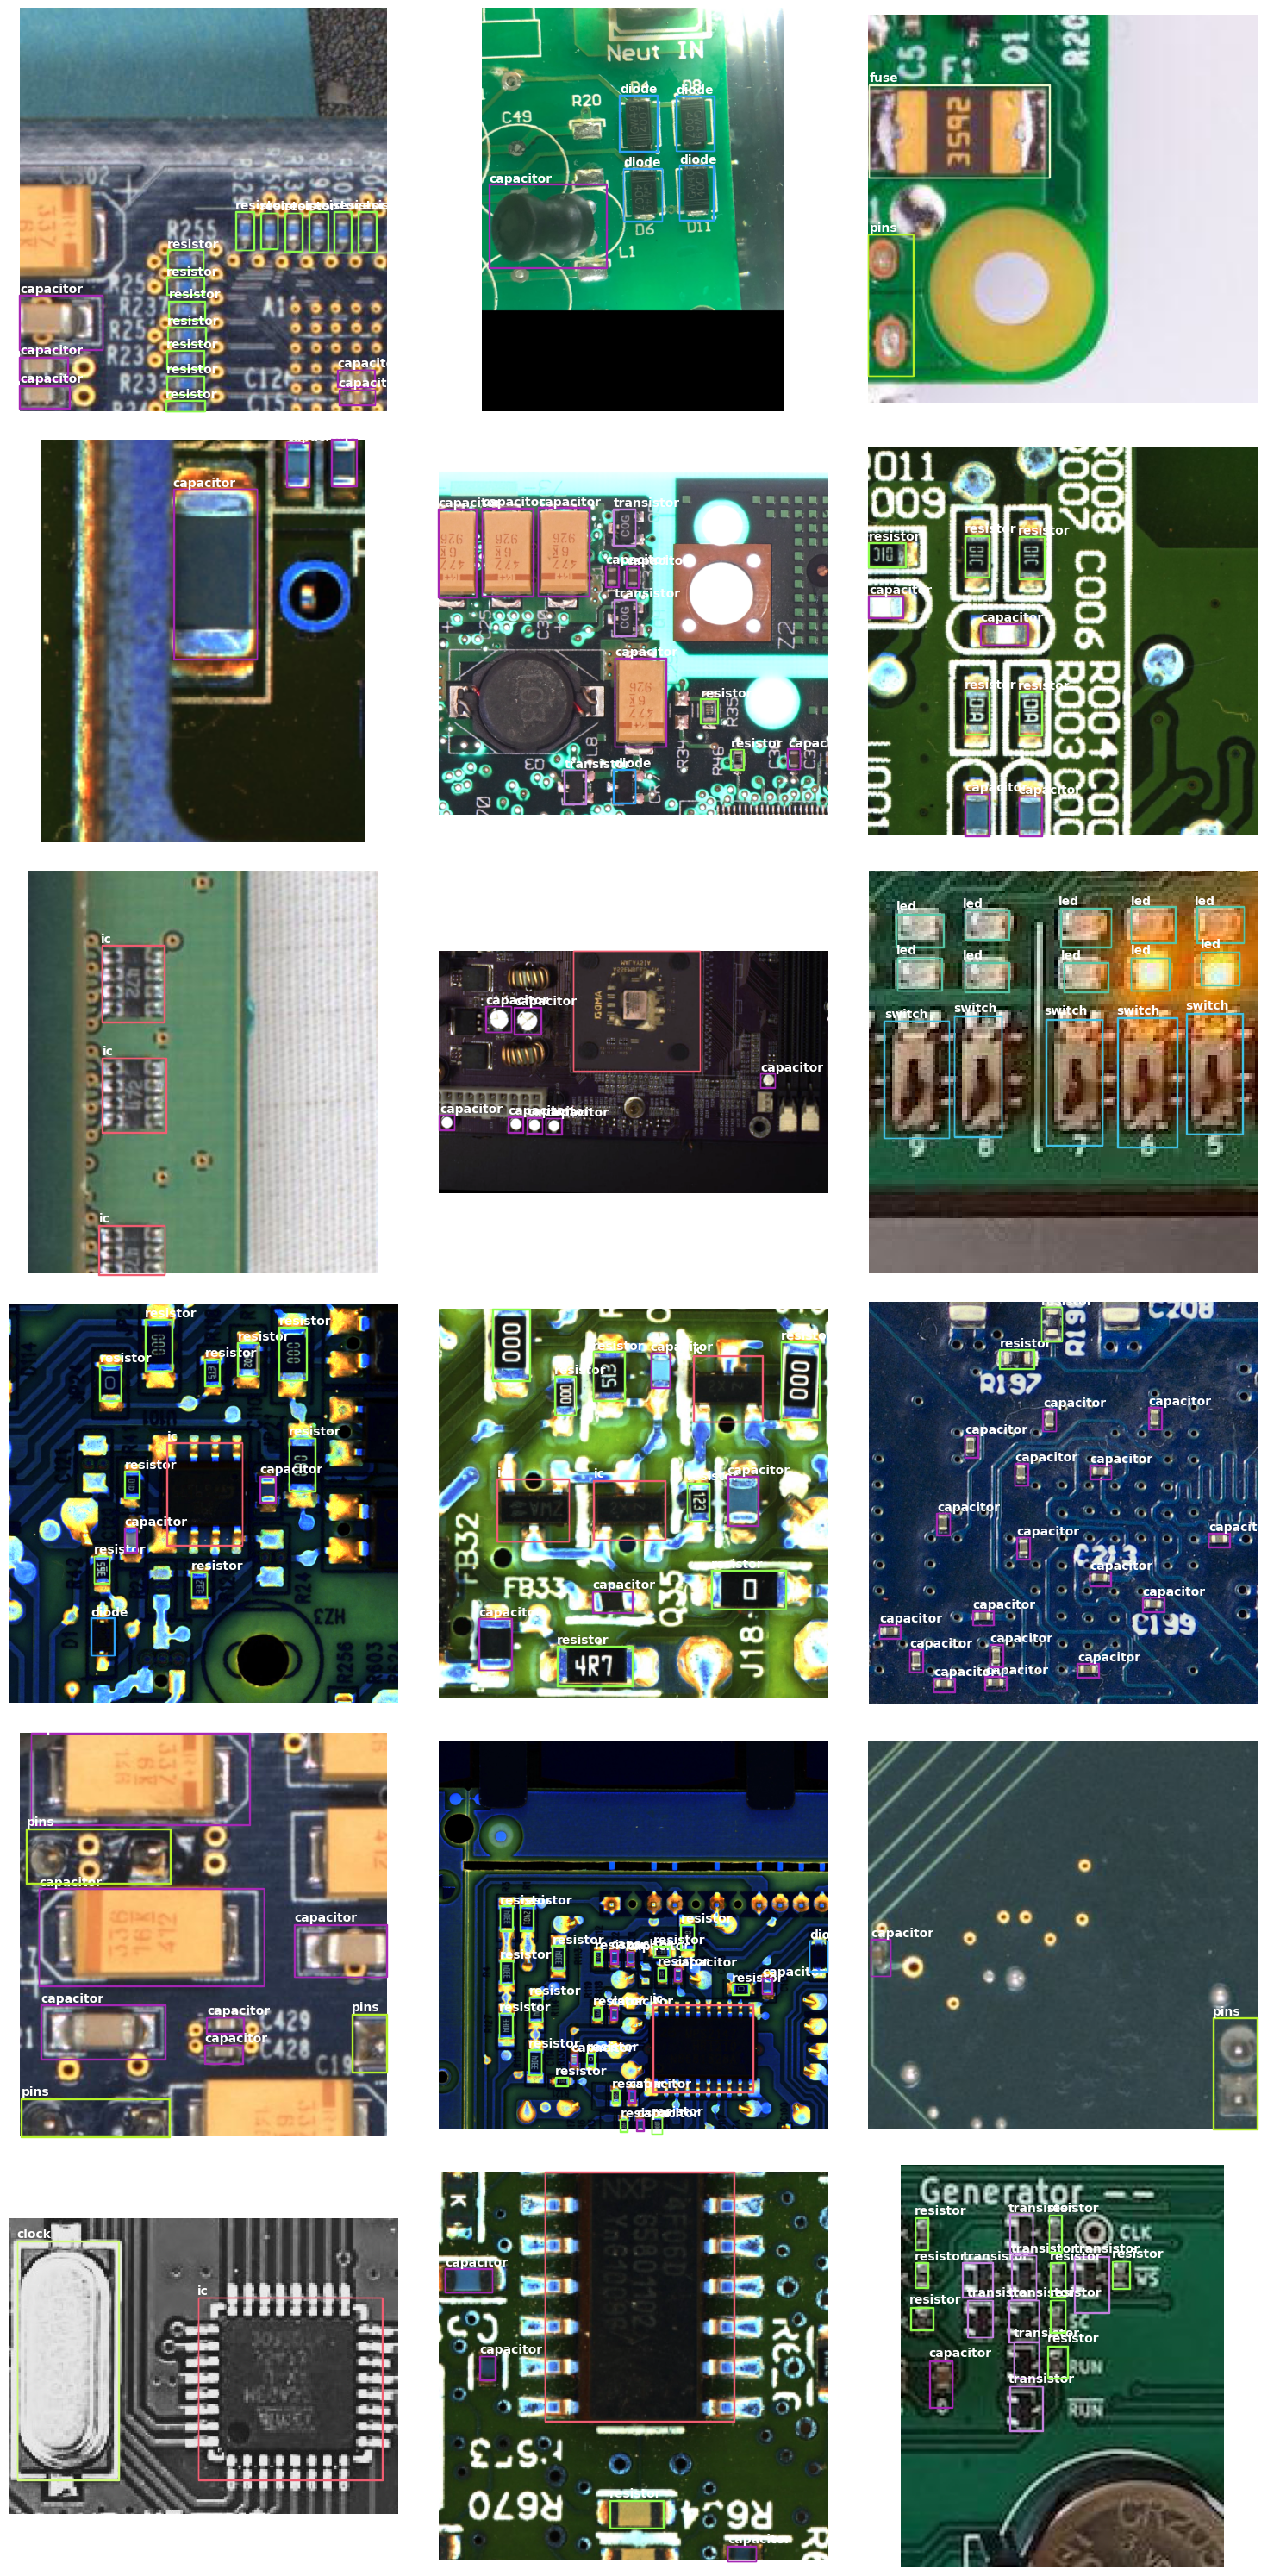

In [14]:
sample_yolo_dataset(COMPONENTS_DATA_DIR / "train", CLASSES)